# Week of 2025.04.14

- [ ]  Atmosphere integration
    - [x]  Couple new conduit flow with slip to atmosphere
    - [x]  Look into Fred’s thesis on 1D/2D pairing with atmosphere
    - [x]  Look into timesteps required for atmosphere integration, verify that a 0 order atmosphere simulation can be added without modifying the time step value. 
    - [ ]  Possibly add simple approximation of atmosphere to lumped parameter
    - [ ]  Look into using linear acoustics to extent lumped parameter model to include outputs for the atmosphere.
- [ ]  Lumped parameter search
    - [ ]  Make lumped parameter model match ‘eruption’ that Mario is experimenting with
    - [ ]  Get inversion code that Mario is working on up and running
- [x] Support Mario with slip feature


# 0 Review Mario's previous eruption input file without slip as baseline

In [ ]:
# TODO

# 1 Review the simulation that Mario developed where the volcano is erupting



Relevant parameters:

$$\tau_{peak} =1e4 \\
\tau_r = 0 \\
D_c = 2 \\
R = 5
$$

**Questions:**
- Speed of sound seems pretty low?
- Water content seems a little high? 
- What is the reason for the crystal content graph? 

In [39]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

solver_func = get_local_solver_from_index_func("eruption_model_no_atmosphere", "tungurahua_rad_5_v23_conduit")

ani = animate_conduit_pressure(solver_func, iterations=90,  viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.2, max_pressure=7, max_speed_of_sound=500, x_min=-1000, x_max=0, max_water=10, max_density=8e2)

HTML(ani.to_html5_video())

# 2 Eruption emulated with lumped parameter model 

Let's start with the [Lumped Parameter model](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.03.26.experiments.html) I was using a couple of weeks ago. 

### 2.1 Review Differential Equations

Let's review the forces at play: 

**Pressure balance:**

$$
\begin{equation}
M \ddot{s} = A p_0 + \Delta p(s) A - p_{atm} A \\
\end{equation}
$$

The $\Delta p (s)$ term is different depending on if we assume a very fast interaction where the conduit is best modeled as an infinite pipe, or if we assume a slower moving interaction where enough time passes to ignore the wave effects:

In the radiation damping fast limit:
$$
\Delta p = - \rho c \dot{s}
$$

In the quasistatic limit: 
$$
\Delta p = \frac{-K s}{L_{melt}}
$$

**Wall friction:**
$$
\begin{equation}
M \ddot{s} = - 2 \pi R \tau(s) (L_{plug} - s)
\end{equation}
$$

At the moment, we are using a liner model for wall friction, so $\tau$ is defined as a piecewise function of slip.

**Viscous friction:**
$$
\begin{equation}
M \ddot{s} = - 4 \pi \mu (L_{melt} + s) \dot{s}
\end{equation}
$$

**Gravity:**

$$
\begin{equation}
M \ddot{s} = -g
\end{equation}
$$

**Overall DE:**

$$
\begin{equation}
M \ddot{s} = A (p_0 - \rho c \dot{s} - p_{atm}) - 2 \pi R \tau(s)(L_{plug} - s) - 4 \pi \mu (L_{melt} + s) \dot{s} - g
\end{equation}
$$

### 2.2 What is missing from the lumped parameter model? 

Fred in his [thesis](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L) say's
> we neglect the friction in the eruptive mixture above the fragmentation front, and set the friction
force proportional to the proportion of unfragmented magma.

1. How do we factor in fragmentation? At the moment I have just turned off viscous friction entirely and that seems to work OK. 
2. Exsolution is also not modeled.
3. At the moment, the quail model seems to predict a velocity of eruption that is greater than the lumped parameter model predicts even with all of the resistive forces turned off. 


What is plotted below is the lumped parameter model with all the resistive forces turned off. That should provide an upper limit on how quickly the volcano erupts.

In [35]:
from scipy.integrate import odeint

# Define constants (you can modify these values as needed)
K = 1e10      # Some constant (friction/damping)
L_melt = 950 # Melt length
tau_peak = 1e4  # principle shear stress
tau_r = 0  # residual shear stress
R = 5      # Radius [m]
L_plug = 50 # Plug length
g = 9.81  # Acceleration due to gravity [m/s^2]

rho = 2e2  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 130 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug * (1 + L_melt / (L_plug*2))
D_c = 2

# viscosity
mu = 5e6

A = np.pi * R**2  # Cross-sectional area
p0 = 5e6  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure


NON_PHYSICAL_VISCOUS_FRICTION_MULTIPLIER = 1.0

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_peak - (tau_peak - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    # ds2/dt = (-A*K*s2)/(M*L_melt) + ((tau_p - tau_s)*2*pi*R*(L_plug - s1)*s1)/M
    ds2_dt = (A * (p0 - p_atm) / M_plug) \
            - (rho * C * s2) / (M_plug)  \
            - (tau(s1) * 2 * np.pi * R * (L_plug - s1)) / M_plug  \
            - g/M_plug \
            - 0.0005 * np.pi * mu * (L_melt+s1) * s2 / M_plug \
    
    return [ds1_dt, ds2_dt]

# Time points
t = np.linspace(0, 2.5, 1000)  # Time from 0 to 10 with 1000 points

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Solve the differential equations
solution = odeint(system, initial_state, t)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

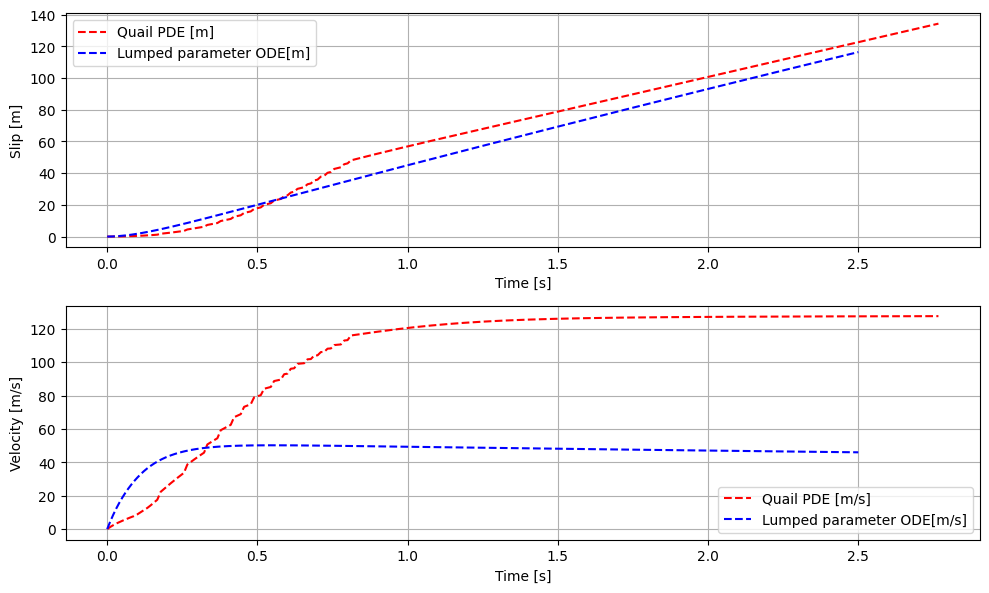

In [36]:
folder = "eruption_model"
file_prefix = "tungurahua_rad_5_v19_conduit"
BASE_PATH = "/Users/paxton/git"
N = 250
slip_time_series = []
ds_dt_quail = []
times = []

for i in range(0, N):
    solver = readwritedatafiles.read_data_file(f"{BASE_PATH}/volcano_sims/{folder}/{file_prefix}_{i}.pkl")
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]

    # Get the position of of each nodal points (location corresponding to each entry of slip)
    nodal_pts = solver.basis.get_nodes(solver.order)
	# Allocate [ne] x [nb, ndims]
    x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)

    for elem_ID in range(solver.mesh.num_elems):
		# Fill coordinates in physical space
	    x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
		
    wall_friction_index = 5
    fsource_tau = solver.physics.source_terms[wall_friction_index]
    plug_boundary = fsource_tau.compute_plug_boundary(solver.state_coeffs, x, solver.physics)

    plug_idx = np.argmin(np.abs(x - plug_boundary))

    #print(f"time {solver.time} Plug boundary: {plug_boundary}, Plug index: {plug_idx}")
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")].ravel()/rho.ravel())[plug_idx])
    ds_dt_quail.append((momentum.ravel()/rho.ravel())[plug_idx])
    times.append(solver.time)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'r--', label='Quail PDE [m]')
plt.plot(t, s1, 'b--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("Slip [m]")
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(times, ds_dt_quail, 'r--', label='Quail PDE [m/s]')
plt.plot(t, s2, 'b--', label='Lumped parameter ODE[m/s]')
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

# 3 Adding atmosphere 
First, let's try the input file that Mario shared with me from [this google drive](https://drive.google.com/drive/folders/1S6SneU5UUz1uZHzF3muXkaw3pXalmXht) to verify that we are able to plot the atmosphere in that simple example. Okay, that worked! 

## Note's from Fred's thesis on atmosphere integration
- axisymmetric, mathmatically two-dimensional model of the atmosphere. Resulting flow is 3D.
- 2D atmosphere domain, the primary concern is to capture the transient structure of the starting eruptive jet.
- Conserve mass, momentum, and energy



## Apply atmosphere to eruption model

In [41]:
solver_func = get_local_solver_from_index_func("eruption_model", "tungurahua_rad_5_v21_conduit")
ani = animate_conduit_pressure(solver_func, iterations=10, viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=7, max_speed_of_sound=250)

HTML(ani.to_html5_video())

In [58]:
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_atm1")

# Extract solver
solver2D = solver2D_from(1)

print("The shape of state_coeffs for 2D is:")
print(solver2D.state_coeffs.shape)

The shape of state_coeffs for 2D is:
(1215, 1, 10)


In [59]:
x_nodes = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs, :]
x_nodes.shape

(1215, 3, 2)

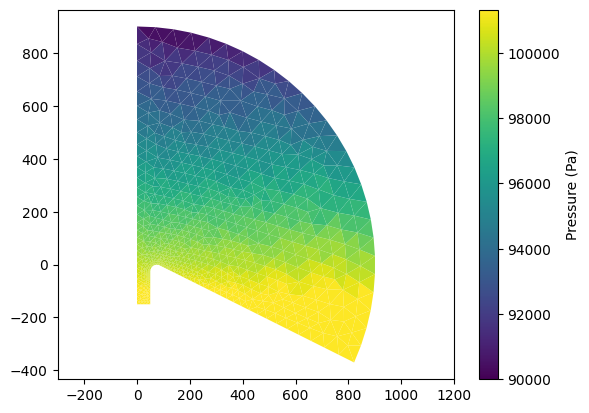

In [60]:
import processing.mdtools as mdtools
import matplotlib

fig = plt.figure()
ax = fig.axes

x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")

clims = (0.9e5, 1.01325e5)

mdtools.plot_mean(x, p, clims)

sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

Now, let's try Fred's tool that returns the pressure at a given coordinate. **Note** in order for this to work, it is important we set `ElementOrder2D = 1`. That is a setting that requires a finer timestep. Otherwise, the shape of the arrays does not work out. I suspect that there is a work around. But for now I am just setting `ElementOrder2D = 1`. 

In [45]:
import matplotlib.tri as tri
triangulation = tri.Triangulation(solver2D.mesh.node_coords[...,0],
                  solver2D.mesh.node_coords[...,1], 
                  triangles=solver2D.mesh.elem_to_node_IDs)
                  
trifinder = triangulation.get_trifinder()

def find_elem_ID(x, y):
  ''' Returns element ID corresponding to given x and y. '''
  return trifinder(x, y)


In [46]:
# Set some point where we want to evaluate pressure
x_target = 500.0
y_target = 0.0

# Find the element ID
elem_ID = find_elem_ID(x_target, y_target)
# Coordinates corresponding to the three nodes in the relevant triangle
x_node_elem = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs[elem_ID,:], :]

U = solver2D.state_coeffs

print(f'x node element shape: {x_node_elem.shape}')
print(f'U shape: {U.shape}')


# Evaluate state_coeff at the exact point (x_target, y_target)
U_target = np.array([tri.CubicTriInterpolator(
    tri.Triangulation(x_node_elem[:,0],x_node_elem[:,1]), # Create local triangulation using x, y of relevant triangle
    U[elem_ID, :, i])(x_target,y_target) for i in range(U.shape[-1])])

# Pad U_target to the right shape for physics.compute_variable
U_target = U_target[np.newaxis, np.newaxis, :]

# Compute pressure using the state vector
p_target = solver2D.physics.compute_variable("Pressure", U_target)
p_target

x node element shape: (3, 2)
U shape: (1215, 3, 10)


array([[[100166.14170247063]]])

### Calculating mesh size and theoretical limit

Physics limit for explicit time step method is 

$$ \Delta t = \frac{min(\Delta x)}{max(u+c)}$$


$max(u+c)$ is generously $500 m/s$. 

And the smallest $\Delta x$ in the mesh for the air is roughly $5m$. In fact, the mesh in the conduit is actuall smaller with an average size of about 2.5 m. If we use the size in the mesh, we get a **theoretical** result of:


$$\Delta t = 1.5 [m] / 500 [m/s] =  5e-3$$


**In practice**, the timestep required by the simulation without atmosphere is $\Delta t = 1e-4$

If we set the `2D solution order = 0`, adding the atmospheric mesh does not required further reduction of the timestep past the $1e-4$ required by the original eruption simulation.

However, if we set `2D solution order = 1` , we do need to further reduce the time step $\Delta t = 5e-6$ to avoid the simulation crashing. 


In [ ]:
def shortest_side(x_node_elem):
    side1 = np.linalg.norm(x_node_elem[0] - x_node_elem[1]) 
    side2 = np.linalg.norm(x_node_elem[1] - x_node_elem[2])
    side3 = np.linalg.norm(x_node_elem[2] - x_node_elem[0])

    return min(side1, side2, side3)

smallest_mesh_size = 100
x_pos = 0
y_pos = 0
for x in range(1000):
    for y in range(-200, 600):
        elem_ID = find_elem_ID(x, y)
        x_node_elem = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs[elem_ID,:], :]
        if shortest_side(x_node_elem) < smallest_mesh_size:
            smallest_mesh_size = shortest_side(x_node_elem)
            x_pos = x
            y_pos = y


print(f"Smallest mesh size: {smallest_mesh_size} at ({x_pos}, {y_pos}) m")

x_node_elem[0]

Smallest mesh size: 6.206079489753531 at (68, -1)


array([401.6587890822837, 282.2446723107805])

# 4 Support Mario with slip feature

## First, Mario is having challenges with the `compute_plug_boundary` call. 

Let's see if we can duplicate his challenges locally. 

In [1]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func

solver_func = get_local_solver_from_index_func("mario_file_review/test_plug_boundary", "tungurahua_rad_5_v15_conduit_")

#ani = animate.animate_conduit_pressure(solver_func, iterations=50, viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=7, max_speed_of_sound=250)
#HTML(ani.to_html5_video())

solver = solver_func(2)
nodal_pts = solver.basis.get_nodes(solver.order)

x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)

for elem_ID in range(solver.mesh.num_elems):
	# Fill coordinates in physical space
	x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)

wall_friction_index = 5
fsource_tau = solver_func(0).physics.source_terms[wall_friction_index]
plug_boundary = fsource_tau.compute_plug_boundary(solver.state_coeffs, x, solver.physics)

print(plug_boundary)

-48.75


Huh `compute_plug_boundary` works just fine for me. I confirm that I am using a main branch of quail. 

## Second, Mario is getting a single value when we call `compute viscosity`.

This one was on me. I wrote the code so that when the 'default_viscosity' is set to true, the compute viscosity function only returns a single viscosity rather than an array of viscosities. I modified the code in this [PR](https://github.com/fredriclam/quail_volcano/pull/29) to have the `compute_viscosity` function now return an array of duplicate viscosity values instead. 

In [4]:
solver = solver_func(5)
viscosity_index = 1
fsource = solver.physics.source_terms[viscosity_index]
viscosity = fsource.compute_viscosity(solver.state_coeffs, solver.physics)

viscosity.shape

(400, 1, 1)